<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/Food_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
drive.mount('/content/drive')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


train, test Îç∞Ïù¥ÌÑ∞ Íµ¨Î∂Ñ


In [40]:
validation_split = .2
batch_size = 32
LR = 1e-3
model_type = "ResNet18_Custom"
criterion = nn.CrossEntropyLoss()
new_model_train = True
shuffle_dataset = True
random_seed= 42

path = "/content/drive/MyDrive/AIIA AFAC/Original_Food_10"

In [41]:
# Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò (Data Augmentation Ï∂îÍ∞Ä)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # ÎûúÎç§ ÌÅ¨Î°≠ & Î¶¨ÏÇ¨Ïù¥Ï¶à
        transforms.RandomHorizontalFlip(p=0.5),  # 50% ÌôïÎ•†Î°ú Ï¢åÏö∞Î∞òÏ†Ñ
        transforms.RandomVerticalFlip(p=0.3),  # 30% ÌôïÎ•†Î°ú ÏÉÅÌïòÎ∞òÏ†Ñ
        transforms.RandomRotation(degrees=30),  # -30ÎèÑ ~ +30ÎèÑ ÌöåÏ†Ñ
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),  # ÏÉâÏÉÅ Î≥ÄÌôî
        transforms.RandomGrayscale(p=0.2),  # 20% ÌôïÎ•†Î°ú ÌùëÎ∞± Î≥ÄÌôò
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Ïù¥Îèô & ÌÅ¨Í∏∞ Î≥ÄÌòï
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # ÏõêÍ∑º ÏôúÍ≥°
        transforms.RandomErasing(p=0.4, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # ÏùºÎ∂Ä ÏòÅÏó≠ ÏÇ≠Ï†ú
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Î∏îÎü¨ Ï†ÅÏö©
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),  # ÏûêÎèô Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Ï†ïÍ∑úÌôî
    ]),

    "test": transforms.Compose([
        transforms.Resize((224, 224)),  # ÌÅ¨Í∏∞Îßå Ï°∞Ï†ï
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
image_datasets = datasets.ImageFolder(path, transform=data_transforms["train"])

# ÌÅ¥ÎûòÏä§ ÌôïÏù∏
class_names = image_datasets.classes


In [42]:
from torch.utils.data import random_split, DataLoader
import numpy as np
dataset_size = len(image_datasets)
test_split = 0.1  # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú® (10%)
val_split = 0.2   # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÎπÑÏú® (20%)

# Í∞úÏàò Í≥ÑÏÇ∞
test_size = int(np.floor(test_split * dataset_size))
val_size = int(np.floor(val_split * dataset_size))
train_size = dataset_size - val_size - test_size  # ÎÇòÎ®∏ÏßÄÎäî ÌïôÏäµ Îç∞Ïù¥ÌÑ∞

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])

# Í≤ÄÏ¶ù & ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÎäî augmentationÏùÑ Ï†ÅÏö©ÌïòÏßÄ ÏïäÎèÑÎ°ù transform ÏàòÏ†ï
val_dataset.dataset.transform = data_transforms["test"]
test_dataset.dataset.transform = data_transforms["test"]

# DataLoader ÏÉùÏÑ±
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Îç∞Ïù¥ÌÑ∞ Î°úÎî© ÌôïÏù∏
inputs, classes = next(iter(train_loader))
print("Train Batch Labels:", classes)


Train Batch Labels: tensor([2, 7, 8, 1, 7, 6, 0, 4, 2, 3, 5, 1, 3, 8, 6, 0, 4, 8, 2, 4, 8, 4, 4, 0,
        2, 8, 4, 6, 5, 7, 6, 1])


In [43]:
from collections import Counter

# Í∞Å SubsetÏóêÏÑú ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Î†àÏù¥Î∏î Í∞ÄÏ†∏Ïò§Í∏∞
train_labels = [image_datasets.targets[i] for i in train_dataset.indices]
val_labels = [image_datasets.targets[i] for i in val_dataset.indices]
tset_labels = [image_datasets.targets[i] for i in test_dataset.indices]

# Î∂ÑÌè¨ ÌôïÏù∏
print("Train Label Distribution:", Counter(train_labels))
print("Validation Label Distribution:", Counter(val_labels))
print("Validation Label Distribution:", Counter(tset_labels))

Train Label Distribution: Counter({1: 722, 5: 712, 8: 708, 6: 706, 3: 700, 0: 699, 4: 694, 7: 687, 2: 676, 9: 18})
Validation Label Distribution: Counter({2: 224, 3: 209, 7: 205, 6: 201, 4: 198, 8: 198, 0: 195, 1: 190, 5: 176, 9: 9})
Validation Label Distribution: Counter({5: 112, 4: 108, 7: 108, 0: 106, 2: 100, 8: 93, 6: 93, 3: 91, 1: 88, 9: 3})


tensor([0, 0, 3, 8, 5, 4, 1, 6, 4, 7, 1, 0, 0, 2, 0, 2, 4, 8, 0, 5, 5, 3, 1, 4,
        8, 8, 4, 2, 3, 5, 2, 3])


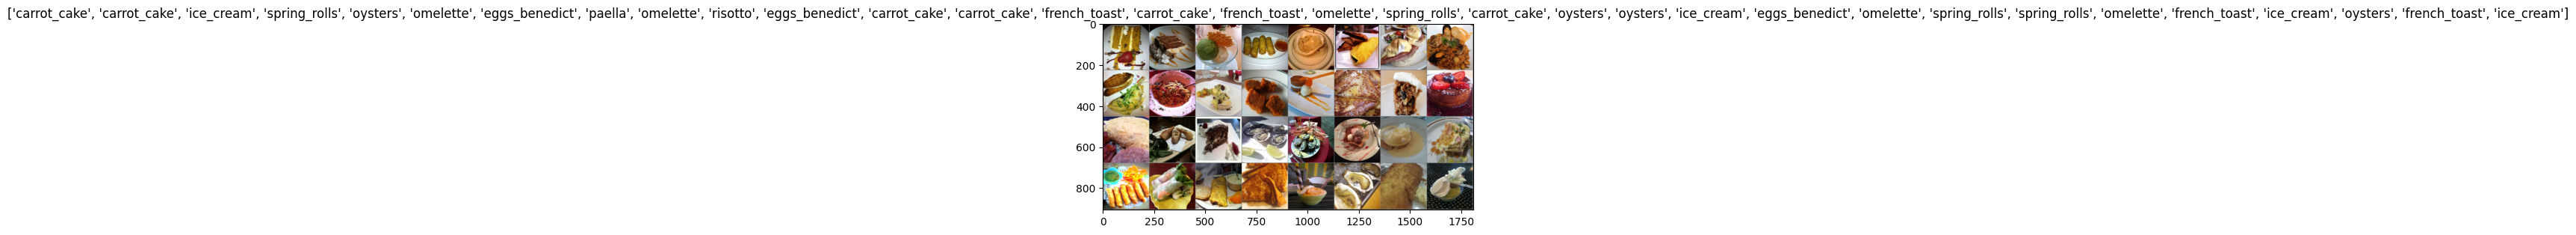

In [44]:
inputs, classes = next(iter(train_loader))
print(classes)
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [45]:
class ResNet18_Custom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_Custom, self).__init__()

        # ResNet-18 Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò§Îêò, Í∏∞Î≥∏ ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎäî Î∂àÎü¨Ïò§ÏßÄ ÏïäÏùå
        self.resnet = models.resnet18(pretrained=False)

        # ÎßàÏßÄÎßâ Fully Connected Î†àÏù¥Ïñ¥Î•º ÏõêÌïòÎäî ÌÅ¥ÎûòÏä§ Í∞úÏàòÎ°ú ÏàòÏ†ï
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        # ResNetÏùò Í∏∞Î≥∏ ÌùêÎ¶ÑÏùÑ Í∑∏ÎåÄÎ°ú Îî∞ÎùºÍ∞ê
        x = self.resnet(x)
        return x

# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
model = ResNet18_Custom(num_classes=len(class_names))  # Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¥ÎûòÏä§ Í∞úÏàòÏóê ÎßûÍ≤å ÏÑ§Ï†ï
model = model.to(DEVICE)  # Î™®Îç∏ÏùÑ GPU/CPUÎ°ú Ïù¥Îèô


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [46]:

# ÏÜêÏã§ Ìï®ÏàòÏôÄ ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


In [47]:
# Î™®Îç∏ Ï†ÄÏû• Ìï®Ïàò
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f" Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: {path}")

def load_model(model, path="best_model.pth", device="cpu"):
    state_dict = torch.load(path, map_location=device)  # ‚úÖ GPU or CPU ÏûêÎèô ÏÑ§Ï†ï
    model.load_state_dict(state_dict)
    model = model.to(device)  # ‚úÖ Î™®Îç∏ÎèÑ GPUÎ°ú Ïù¥Îèô
    print(f"üîπ Model loaded from {path} to {device}")
    return model

In [49]:
# Early Stopping ÏÑ§Ï†ï
num_epochs = 30
patience = 5  # Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏïÑÎèÑ Î™á epochÍπåÏßÄ Í∏∞Îã§Î¶¥ÏßÄ
best_loss = float("inf")  # ÏµúÏÜå Validation Loss Ï†ÄÏû•
counter = 0  # Early Stopping Ï≤¥ÌÅ¨Ïö© Ïπ¥Ïö¥ÌÑ∞

# ÌïôÏäµ Í∏∞Î°ù Ï†ÄÏû•Ïö©
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• Í≤ΩÎ°ú
checkpoint_path = "checkpoint.pth"

# ÌïôÏäµ Î£®ÌîÑ
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Í≤ÄÏ¶ù Î£®ÌîÑ (Validation Loss & Accuracy Í≥ÑÏÇ∞)
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(validation_loader)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ÌïôÏäµ Í∏∞Î°ù Ï†ÄÏû•
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Early Stopping Ï≤¥ÌÅ¨
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0  # Í∞úÏÑ†ÎêòÏóàÏúºÎØÄÎ°ú counter Ï¥àÍ∏∞Ìôî
        # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"‚úÖ Checkpoint saved at epoch {epoch+1}, loss: {avg_val_loss:.4f}")
    else:
        counter += 1  # Í∞úÏÑ†ÎêòÏßÄ ÏïäÏïòÏúºÎØÄÎ°ú counter Ï¶ùÍ∞Ä
        print(f"‚ö†Ô∏è Early Stopping Counter: {counter}/{patience}")

    # patience Ïù¥ÏÉÅÏúºÎ°ú Í∞úÏÑ†Ïù¥ ÏóÜÏúºÎ©¥ ÌïôÏäµ Ï§ëÎã®
    if counter >= patience:
        print("‚õî Early stopping triggered! Training stopped.")
        break

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ÏóêÏÑú ÏµúÏ†Å Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")


Epoch 1/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:07<00:00,  2.93it/s, loss=1.2]


Epoch 1/30, Train Loss: 1.6326, Train Acc: 0.4288, Val Loss: 1.9348, Val Acc: 0.3584
‚úÖ Checkpoint saved at epoch 1, loss: 1.9348


Epoch 2/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:06<00:00,  3.00it/s, loss=1.3]


Epoch 2/30, Train Loss: 1.5066, Train Acc: 0.4750, Val Loss: 1.5479, Val Acc: 0.4753
‚úÖ Checkpoint saved at epoch 2, loss: 1.5479


Epoch 3/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.01it/s, loss=1.74]


Epoch 3/30, Train Loss: 1.4061, Train Acc: 0.5174, Val Loss: 1.4929, Val Acc: 0.4881
‚úÖ Checkpoint saved at epoch 3, loss: 1.4929


Epoch 4/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.02it/s, loss=1.42]


Epoch 4/30, Train Loss: 1.3060, Train Acc: 0.5512, Val Loss: 1.6317, Val Acc: 0.4587
‚ö†Ô∏è Early Stopping Counter: 1/5


Epoch 5/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.02it/s, loss=1.22]


Epoch 5/30, Train Loss: 1.2006, Train Acc: 0.5938, Val Loss: 1.4630, Val Acc: 0.5252
‚úÖ Checkpoint saved at epoch 5, loss: 1.4630


Epoch 6/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.02it/s, loss=1.52]


Epoch 6/30, Train Loss: 1.1253, Train Acc: 0.6239, Val Loss: 2.1587, Val Acc: 0.3856
‚ö†Ô∏è Early Stopping Counter: 1/5


Epoch 7/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.03it/s, loss=1.61]


Epoch 7/30, Train Loss: 1.0779, Train Acc: 0.6376, Val Loss: 1.5916, Val Acc: 0.5069
‚ö†Ô∏è Early Stopping Counter: 2/5


Epoch 8/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.04it/s, loss=1.24]


Epoch 8/30, Train Loss: 0.9981, Train Acc: 0.6588, Val Loss: 1.4839, Val Acc: 0.5363
‚ö†Ô∏è Early Stopping Counter: 3/5


Epoch 9/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:04<00:00,  3.05it/s, loss=1.16]


Epoch 9/30, Train Loss: 0.9152, Train Acc: 0.6884, Val Loss: 1.6449, Val Acc: 0.5003
‚ö†Ô∏è Early Stopping Counter: 4/5


Epoch 10/30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 198/198 [01:05<00:00,  3.04it/s, loss=1.69]


Epoch 10/30, Train Loss: 0.8159, Train Acc: 0.7254, Val Loss: 1.5325, Val Acc: 0.5396
‚ö†Ô∏è Early Stopping Counter: 5/5
‚õî Early stopping triggered! Training stopped.
‚úÖ Model restored from checkpoint at epoch 5, loss: 1.4630


<ipython-input-49-347a27c72d41>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


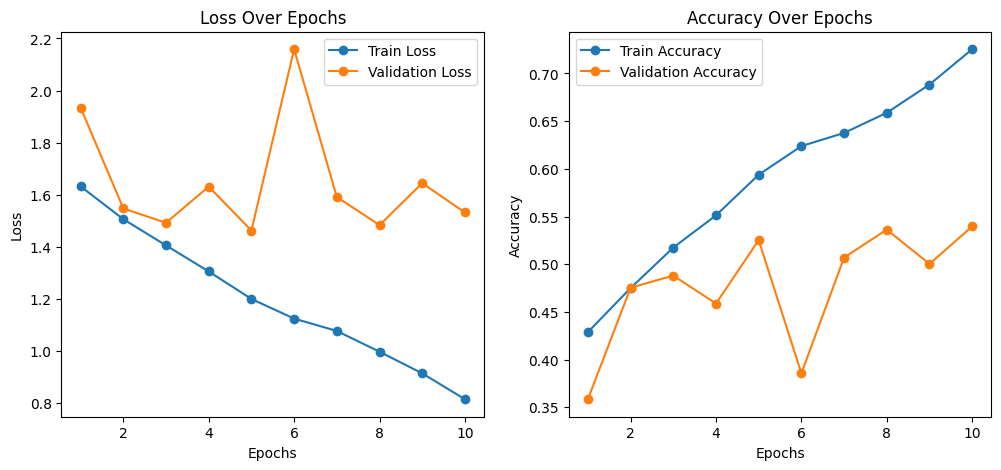

In [50]:
plot_training(history)

<ipython-input-51-b819c06ce8c0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model restored from checkpoint at epoch 5, loss: 1.4630
 Validation Loss: 1.4630, Accuracy: 52.52%
Final Validation Loss: 1.4630, Final Validation Accuracy: 52.5208


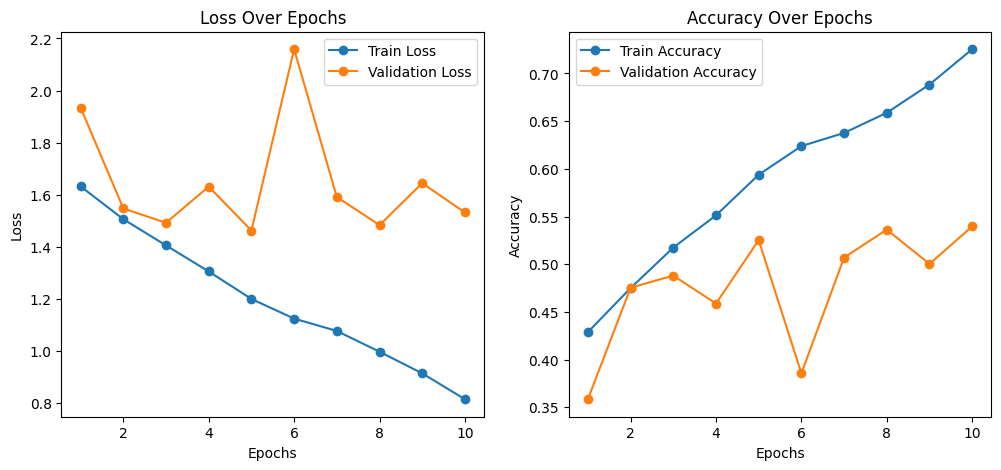

In [51]:
# ÌïôÏäµÏù¥ ÎÅùÎÇú ÌõÑ, Í∞ÄÏû• Ï¢ãÏùÄ Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")

# ÌïôÏäµ ÏôÑÎ£å ÌõÑ ÏµúÏ¢Ö Validation ÏÑ±Îä• ÌôïÏù∏
final_val_loss, final_val_acc = validate_model(model, validation_loader, DEVICE)
print(f"Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_acc:.4f}")

# ÌïôÏäµ Í≥ºÏ†ï Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞ (ÌïÑÏöîÌïú Í≤ΩÏö∞)
plot_training(history)  # ÌïôÏäµ Í≥ºÏ†ï ÏãúÍ∞ÅÌôî
